# GNN Code, mostly taken from Luke van Poppering

### Latex Macros
$\newcommand{\Re}[1]{{\mathbb{R}^{{#1}}}}
\newcommand{\Rez}{{\mathbb{R}}}$

In [6]:
%load_ext autoreload
%autoreload 2
#%tableofcontents

In [7]:
import torch
import torch_scatter
import torch_sparse
import torch_geometric
import tqdm.auto
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import GNN_Tools as GNNT

In [8]:
### We use the famous 'Karate Club' network as a test case. Our task is to
### predict the community to which each node belongs; formally, this would be
### called transductive binary node classification.

import networkx as nx
G = nx.karate_club_graph()

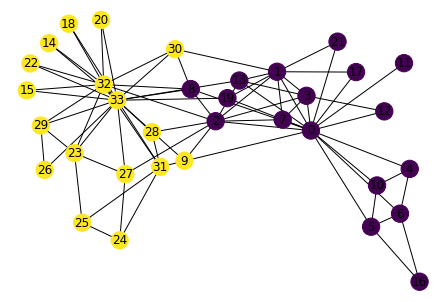

In [9]:
### Plot the network. We see it consists of a total of 34 nodes (numbered below 
### 0-33). Colors indicate class membership.
labels = [0 if G.nodes[idx]['club'] == 'Mr. Hi' else 1 for idx in range(len(G.nodes))]
pos = nx.drawing.layout.spring_layout(G)
nx.drawing.draw(G,pos=pos,with_labels=True,node_color=labels) 

In [10]:
### Write edge list to file.
### The attributes are synthetic
torch.manual_seed(0)
with open('edges.txt','w') as f:
  for edge in list(G.edges):
    f.write(f'{edge[0]} {edge[1]} {1.0}\n')

### Write node metadata to file. Nodes belonging to class '0' have features
### drawn from N(1,1). Nodes belonging to class '1' have features drawn from 
### the standard normal. So the features are the class label + 16 random numbers, 
### where the mean depends on the class. 
nb_Gnodes = len(list(G.nodes))
nb_rand_features = 3   # change value for experimentation
rands = np.random.randn(nb_Gnodes, 16)
with open('nodes.txt','w') as f:
  for node in list(G.nodes):
      if G.nodes[node]['club'] == 'Mr. Hi':
          X_str = " ".join([str(.5 + rand) for rand in np.random.randn(nb_rand_features)])
          f.write(f'{node} 0 ' + X_str + ' \n')
      elif G.nodes[node]['club'] == 'Officer':
          X_str = " ".join([str(rand) for rand in np.random.randn(nb_rand_features)])
          f.write(f'{node} 1 ' + X_str + ' \n')

### Read files into _Graph_ object.
karate_club_graph = GNNT.Graph()
karate_club_graph.read_edges('edges.txt')
karate_club_graph.read_node_metadata('nodes.txt')

In [11]:
len(G.nodes)
import numpy.linalg as alg

In [12]:
graph = karate_club_graph

Linear model is 
$$ H^{n+1} = A H^n W $$
where $H\in \Re{N\times d}$, $A\in\Re{N\times N}$, and $W\in\Re{d\times d}$ and $d$ is the number of features. In our synthetic example, we have 16 features, one label. `

In [164]:
softmax = torch.nn.functional.softmax
relu = torch.nn.functional.relu
sigmoid = torch.nn.functional.sigmoid
tanh = torch.nn.functional.tanh
activation = relu

def model(A, H0, W):
    """
    W : list of weights of different shapes
    """
    X = activation(A @ H0 @ W[0])
    X = activation(A @ X @ W[1])
    X = softmax(X, dim=1)
    # print("shape X: ", X.shape)
    return X

In [165]:
### Create a hand-crafted GNN without using a formal model.

def model_setup(G, graph):
    """
    G is a networkx graph
    graph is an instance of the Graph class (Luke VP)
    """
    # Ensure result reproducibility
    torch.manual_seed(100)
    nb_nodes = len(G.nodes)
    nb_edges = len(G.edges)
    A = nx.linalg.graphmatrix.adjacency_matrix(G).toarray()
    # Check that graph is undirected if ||A-A.T|| = 0

    An = np.eye(nb_nodes) + A
    Asq = alg.inv(np.sqrt(An))
    An = Asq @ An * Asq
    eig = alg.eig(An)[0]
    
    H0 = graph.node_metadata
    Y = H0[:,0]  # labels
    H0 = H0[:,1:]  # features
    # Use -1 in case the matrix eventually changes number of dimensions
    nb_features = H0.shape[-1]   # last index
    # Initialize W with random numbers and allow gradient 
    # computation of cost function with respect to (wrt) W

    W0 = torch.rand(nb_features, nb_features, requires_grad=True) 
    # Binary classification (2 output features)
    W1 = torch.rand(nb_features, 2, requires_grad=True) 
    W = [W0, W1]
    
    A = torch.tensor(A, dtype=torch.float32)
    
    # Using a sigmoid woudl reduce the range
    # Using ReLu would not reduce the range so normalizaiton must be done
    #   diffently
    H = H0
    return A, H, H0, Y, W

In [166]:
def cost(H, edge_index, node_metadata, Y):
    """
    summation over all edges
    """
    # Prediction matches target if: 
    #    Y[i]==1 <===> H[i,0] > H[i,1]
    #    Y[i]==0 <===> H[i,1] > H[i,0]
    costf = 0.
    for i in range(Y.shape[0]):
        costf -= (Y[i] * torch.log(H[i,0]) + (1-Y[i]) * torch.log(H[i,1]))
    
    return costf

In [187]:
def train(A, H, H0, Y, W, graph):
    
    # Follow https://www.analyticsvidhya.com/blog/2021/08/linear-regression-and-gradient-descent-in-pytorch/
    loss = []
    nb_epoch = 1000
    for iterat in range(nb_epoch):
        H = model(A, H0, W)

        costf = cost(H, graph.edge_index, graph.node_metadata, Y)
        loss.append(costf)
        with torch.no_grad():
            costf.backward(retain_graph=True)  # otherwise graph is discarded. How to regenerate it?
            lr= 1.e-3  # try with 1e-2, 1e-3,,1e-4
            W[0] -= lr * W[0].grad
            W[1] -= lr * W[1].grad
            W[0].grad.zero_()
            W[1].grad.zero_()
    return loss

In [188]:
def predict(A, H0, Y, W):
    
    # Follow https://www.analyticsvidhya.com/blog/2021/08/linear-regression-and-gradient-descent-in-pytorch/
    loss = []
    H = model(A, H0, W)
    print(torch.hstack([H,Y.reshape(34,1)]))

<ipython-input-189-d3d5336e64f0>:1: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(np.asarray(loss)),'-o')


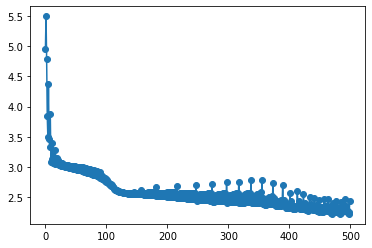

In [189]:
    plt.plot(np.log(np.asarray(loss)),'-o')
    plt.draw()

In [190]:
A, H, H0, Y, W = model_setup(G, graph) 
loss = train(A, H, H0, Y, W, graph)
predict(A, H0, Y, W)

tensor([[2.4525e-02, 9.7548e-01, 0.0000e+00],
        [9.2182e-01, 7.8184e-02, 0.0000e+00],
        [1.9811e-04, 9.9980e-01, 0.0000e+00],
        [2.1289e-02, 9.7871e-01, 0.0000e+00],
        [1.3337e-03, 9.9867e-01, 0.0000e+00],
        [1.3337e-03, 9.9867e-01, 0.0000e+00],
        [3.2165e-04, 9.9968e-01, 0.0000e+00],
        [3.8948e-03, 9.9611e-01, 0.0000e+00],
        [9.6480e-01, 3.5198e-02, 0.0000e+00],
        [9.9278e-01, 7.2185e-03, 1.0000e+00],
        [3.2165e-04, 9.9968e-01, 0.0000e+00],
        [6.4154e-03, 9.9358e-01, 0.0000e+00],
        [3.4956e-04, 9.9965e-01, 0.0000e+00],
        [1.5945e-02, 9.8406e-01, 0.0000e+00],
        [7.8858e-01, 2.1142e-01, 1.0000e+00],
        [7.8858e-01, 2.1142e-01, 1.0000e+00],
        [2.3278e-02, 9.7672e-01, 0.0000e+00],
        [2.1706e-03, 9.9783e-01, 0.0000e+00],
        [7.8858e-01, 2.1142e-01, 1.0000e+00],
        [8.9340e-03, 9.9107e-01, 0.0000e+00],
        [7.8858e-01, 2.1142e-01, 1.0000e+00],
        [2.1706e-03, 9.9783e-01, 0

In [ ]:
 a   